## Install Library

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [101]:
df = pd.read_csv('Fashion_Retail_Sales.csv')
df.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
0,4018,Handbag,4619.0,2023-02-05,NaN,Credit Card
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Reference ID  3400 non-null   int64  
 1   Item Purchased         3400 non-null   object 
 2   Purchase Amount (USD)  2750 non-null   float64
 3   Date Purchase          3400 non-null   object 
 4   Review Rating          3076 non-null   float64
 5   Payment Method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 159.5+ KB


In [103]:
df.describe(include="all")

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
count,3400.000000,3400,2750.000000,3400,3076.000000,3400
unique,NaN,50,NaN,365,NaN,2
top,NaN,Belt,NaN,2023-09-22,NaN,Credit Card
freq,NaN,90,NaN,17,NaN,1770
mean,4039.660588,NaN,156.709818,NaN,2.999057,NaN
std,48.122583,NaN,419.536669,NaN,1.156505,NaN
min,3957.000000,NaN,10.000000,NaN,1.000000,NaN
25%,3997.000000,NaN,57.000000,NaN,2.000000,NaN
50%,4040.000000,NaN,110.000000,NaN,3.000000,NaN
75%,4081.000000,NaN,155.750000,NaN,4.000000,NaN


## Cleaning Data

In [104]:
df = df.dropna(subset=['Purchase Amount (USD)'])
df['Review Rating'] = df['Review Rating'].fillna(df['Review Rating'].mean())

In [105]:
df['Date Purchase'] = pd.to_datetime(df['Date Purchase'])
df = df.sort_values('Date Purchase')

## Preprocessing  Data

In [106]:
df_daily = df.set_index('Date Purchase').resample('D').agg({
    'Purchase Amount (USD)': 'sum',
    'Item Purchased': 'count',
    'Review Rating': 'mean'
}).fillna(0)

In [107]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_daily[['Purchase Amount (USD)']])

In [108]:
n_steps = 30
X, y = [], []
for i in range(n_steps, len(scaled_values)):
    X.append(scaled_values[i-n_steps:i])
    y.append(scaled_values[i])
X, y = np.array(X), np.array(y)

In [109]:
train_size = int(len(df_daily) * 0.8)
X_train, X_test = X[:train_size - n_steps], X[train_size - n_steps:]
y_train, y_test = y[:train_size - n_steps], y[train_size - n_steps:]

train_sarimax = df_daily['Purchase Amount (USD)'].iloc[:train_size]
test_sarimax = df_daily['Purchase Amount (USD)'].iloc[train_size:]


## Modelling

In [110]:
sarimax_model = SARIMAX(train_sarimax, order=(1,1,1), seasonal_order=(1,1,1,7))
sarimax_result = sarimax_model.fit(maxiter=300, method='lbfgs', disp=True)
sarimax_pred = sarimax_result.get_forecast(steps=len(test_sarimax)).predicted_mean

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63252D+00    |proj g|=  6.73906D-02

At iterate    1    f=  8.59509D+00    |proj g|=  1.11205D-01

At iterate    2    f=  8.56310D+00    |proj g|=  1.12751D-02

At iterate    3    f=  8.55958D+00    |proj g|=  1.79614D-02

At iterate    4    f=  8.55626D+00    |proj g|=  1.35246D-02

At iterate    5    f=  8.55474D+00    |proj g|=  1.03011D-02

At iterate    6    f=  8.55421D+00    |proj g|=  2.67022D-03

At iterate    7    f=  8.55404D+00    |proj g|=  2.06283D-03

At iterate    8    f=  8.55385D+00    |proj g|=  2.12828D-03

At iterate    9    f=  8.55343D+00    |proj g|=  4.99057D-03

At iterate   10    f=  8.55275D+00    |proj g|=  7.22763D-03

At iterate   11    f=  8.55212D+00    |proj g|=  6.23105D-03

At iterate   12    f=  8.55206D+00    |proj g|=  7.12988D-04

At iterate   13    f=  8.5

 This problem is unconstrained.



At iterate   18    f=  8.55194D+00    |proj g|=  2.88210D-03

At iterate   19    f=  8.55168D+00    |proj g|=  3.90546D-03

At iterate   20    f=  8.54134D+00    |proj g|=  5.40058D-02

At iterate   21    f=  8.53496D+00    |proj g|=  1.14900D-01

At iterate   22    f=  8.50806D+00    |proj g|=  1.56624D-01

At iterate   23    f=  8.48116D+00    |proj g|=  1.89812D-01

At iterate   24    f=  8.43338D+00    |proj g|=  7.80841D-02

At iterate   25    f=  8.43075D+00    |proj g|=  7.32916D-02

At iterate   26    f=  8.42714D+00    |proj g|=  7.81573D-03

At iterate   27    f=  8.42665D+00    |proj g|=  7.16403D-03

At iterate   28    f=  8.42581D+00    |proj g|=  1.27363D-02

At iterate   29    f=  8.42503D+00    |proj g|=  6.41911D-03

At iterate   30    f=  8.42465D+00    |proj g|=  1.35400D-03

At iterate   31    f=  8.42446D+00    |proj g|=  9.17269D-04

At iterate   32    f=  8.42433D+00    |proj g|=  1.15239D-03

At iterate   33    f=  8.42431D+00    |proj g|=  4.38019D-03

At iter

In [111]:
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(n_steps, 1)))
model.add(Dropout(0.2))
model.add(GRU(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Prediksi dan inverse transform
y_pred_gru = model.predict(X_test)
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)
y_test_inv = scaler.inverse_transform(y_test)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0269
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0205
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0224
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0217
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0222
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0185
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0213
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0203
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168
Epoch 16/20
17/17 ━

## Evaluating

In [112]:
# SARIMAX
mae_sarimax = mean_absolute_error(test_sarimax, sarimax_pred)
mape_sarimax = mean_absolute_percentage_error(test_sarimax, sarimax_pred) * 100
r2_sarimax = r2_score(test_sarimax, sarimax_pred)

# GRU
mae_gru = mean_absolute_error(y_test_inv, y_pred_gru_inv)
mape_gru = mean_absolute_percentage_error(y_test_inv, y_pred_gru_inv) * 100
r2_gru = r2_score(y_test_inv, y_pred_gru_inv)


In [113]:
print("=== SARIMAX Evaluation ===")
print(f"RMSE  : {rmse_sarimax:.2f}")
print(f"MAE   : {mae_sarimax:.2f}")
print(f"MAPE  : {mape_sarimax:.2f}%")
print(f"R2    : {r2_sarimax:.2f}")

print("\n=== GRU Evaluation ===")
print(f"RMSE  : {rmse_gru:.2f}")
print(f"MAE   : {mae_gru:.2f}")
print(f"MAPE  : {mape_gru:.2f}%")
print(f"R2    : {r2_gru:.2f}")


=== SARIMAX Evaluation ===
RMSE  : 950.26
MAE   : 698.49
MAPE  : 100.67%
R2    : -0.16

=== GRU Evaluation ===
RMSE  : 927.89
MAE   : 536.20
MAPE  : 73.32%
R2    : -0.03


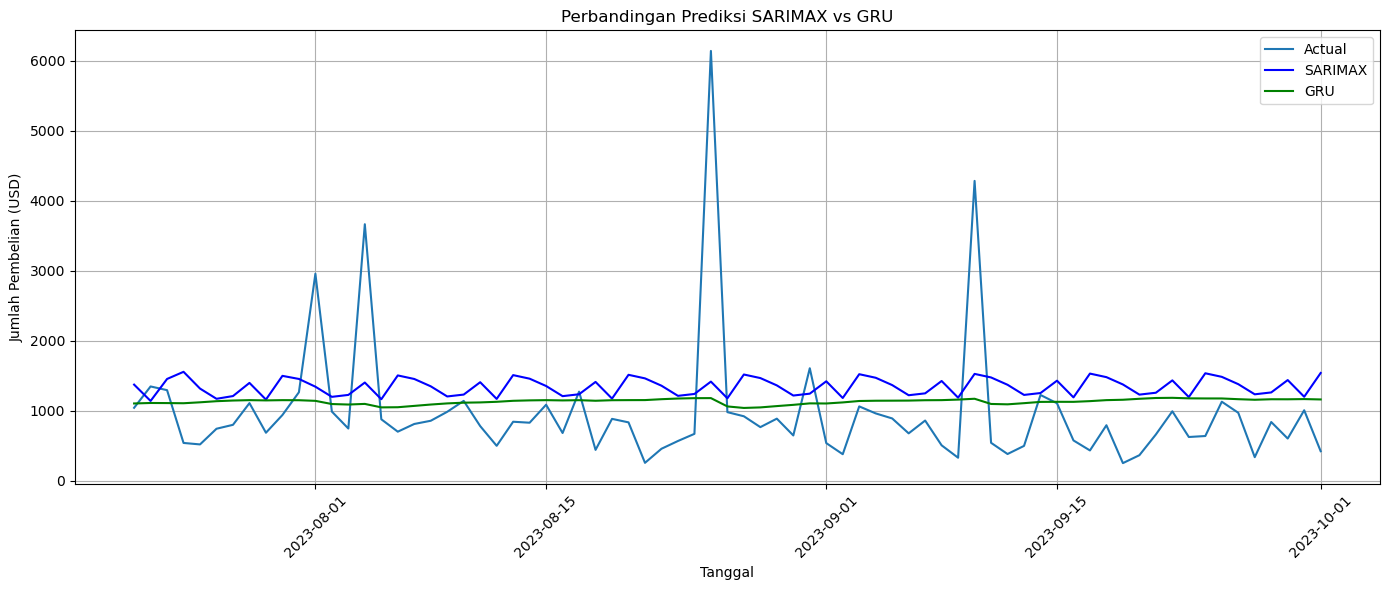

In [114]:
plt.figure(figsize=(14,6))
plt.plot(test_sarimax.index, test_sarimax, label='Actual')  # ✅ Benar
plt.plot(test_sarimax.index, sarimax_pred, label='SARIMAX', color='blue')
plt.plot(test_sarimax.index[-len(y_pred_gru):], y_pred_gru_inv, label='GRU', color='green')

plt.title("Perbandingan Prediksi SARIMAX vs GRU")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pembelian (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()